In [1]:
import numpy as np
import scipy as sp
import scipy.interpolate
import scipy.integrate
import glob
import yt
import distutils.util
yt.set_log_level(0)

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
mpl.rcParams["figure.facecolor"]="white"

In [4]:
#import Athena parameter file reading
import sys
sys.path.insert(0, '/home/forrest/MSU/research/code/athena-public-version/vis/python')
import athena_read

# Load the param file, first and second datasets, parameters

In [5]:

#Define the root directory where phdf files are stored (this is my ctest directory)
data_dir="/home/forrest/MSU/research/code/athenaPK/build-vscode/tst/regression/outputs/cluster_magnetic_tower/"

#Define which feedback mode and whether to check the precessed jet
feedback_mode = "const_field"
precessed=True

testname = f"{feedback_mode}_precessed_{precessed}"


params = athena_read.athinput(
    "/home/forrest/MSU/research/code/athenaPK/inputs/cluster/magnetic_tower.in")

In [6]:
#Load up the first dataset as ds0
out_idx = 0
filename = f"{data_dir}/parthenon.{testname}.{out_idx:05d}.phdf"
ds0 = yt.load(filename, unit_system="cgs")#,units_override=units_override)

#Load up the second dataset as ds0
out_idx = 1
filename = f"{data_dir}/parthenon.{testname}.{out_idx:05d}.phdf"
ds1 = yt.load(filename, unit_system="cgs")#,units_override=units_override)

magnetic_units = 'sqrt(code_mass)/sqrt(code_length)/code_time'

yt : [WARNING  ] 2021-08-19 08:29:35,586 Assuming 1.0 = 1.0 K


In [7]:
#Get the parameters for the feedback field    
mt_alpha = params["problem/cluster/magnetic_tower"]["alpha"]
mt_l     = ds1.quan(params["problem/cluster/magnetic_tower"]["l_scale"],'code_length')

#Get the parameters for the initial field
mt_field0 = ds0.quan(params["problem/cluster/magnetic_tower"]["initial_field"],
                     'sqrt(code_mass)/sqrt(code_length)/code_time')

#Compute initial magnetic energy analytically, integrating to infinity
anyl_B_eng0 = mt_field0**2*(np.pi**(3./2.)*(5 + mt_alpha**2)*mt_l**3)/(8*np.sqrt(2))


tlim = ds1.current_time

if feedback_mode == "const_field":
    mt_field_rate = ds1.quan(params["problem/cluster/magnetic_tower"]["fixed_field_rate"],
                             'sqrt(code_mass)/sqrt(code_length)/code_time**2')
    #Compute expected magnetic field at time step
    mt_field1 = mt_field0 + mt_field_rate*tlim
    #Compute expected magnetic energy analytically, integrating to infinity
    anyl_B_eng1 = mt_field1**2*(np.pi**(3./2.)*(5 + mt_alpha**2)*mt_l**3)/(8*np.sqrt(2))
    
elif feedback_mode == "const_power":
    mt_power = ds1.quan(params["problem/cluster/agn_feedback"]["agn_power"],
                        "code_length**2*code_mass/code_time**3")
    #Compute expected magnetic field at time step
    anyl_B_eng1 = anyl_B_eng0 + mt_power*tlim
    #Compute expected magnetic energy analytically, integrating to infinity
    mt_field1 = np.sqrt(anyl_B_eng1/((np.pi**(3./2.)*(5 + mt_alpha**2)*mt_l**3)/(8*np.sqrt(2))))

#Get jet coords
theta_jet = params["problem/cluster/precessing_jet"]["jet_theta"]
phi_dot_jet = ds1.quan(params["problem/cluster/precessing_jet"]["jet_phi_dot"],'1/code_time')
phi0_jet = params["problem/cluster/precessing_jet"]["jet_phi0"]


anyl_B_eng0 /= 4*np.pi
anyl_B_eng1 /= 4*np.pi

## Define the precessing jet

In [8]:
class PrecessedJetCoords:
    #Note: Does note rotate the vector around the jet axis, only rotates the vector to `z_hat`
    def __init__(self,phi_jet,theta_jet):
        self.phi_jet = phi_jet
        self.theta_jet = theta_jet
        

    def cart_to_jet_coords(self,pos_sim):
        """
        Convert from cartesian coordinates to jet coordinates
        """
        x_sim = pos_sim[0]
        y_sim = pos_sim[1]
        z_sim = pos_sim[2]

        x_jet = x_sim*np.cos(self.phi_jet)*np.cos(self.theta_jet) + y_sim*np.sin(self.phi_jet) - z_sim*np.sin(self.theta_jet)*np.cos(self.phi_jet)
        y_jet = -x_sim*np.sin(self.phi_jet)*np.cos(self.theta_jet) + y_sim*np.cos(self.phi_jet) + z_sim*np.sin(self.phi_jet)*np.sin(self.theta_jet)
        z_jet = x_sim*np.sin(self.theta_jet) + z_sim*np.cos(self.theta_jet)

        r_jet = np.sqrt( x_jet**2 + y_jet**2)
        theta_jet = np.arctan2(y_jet,x_jet)
        h_jet = z_jet
        
        return (r_jet, theta_jet, h_jet)

    def jet_to_cart_vec(self,pos_cart,vec_jet):
        """
        Convert from jet vector to cartesian vector
        """
        r_pos, theta_pos, h_pos = self.cart_to_jet_coords(pos_cart)

        #Convert jet-cylindrical vec_jet into jet-cartesian
        R = np.array((( np.cos(theta_pos),-np.sin(theta_pos), np.zeros_like(theta_pos)),
                      ( np.sin(theta_pos), np.cos(theta_pos), np.zeros_like(theta_pos)),
                      ( np.zeros_like(theta_pos),np.zeros_like(theta_pos), np.ones_like(theta_pos)))).reshape(
                              (3,3,*(theta_pos.shape)))
        #vec_jet_cart = np.einsum("ij,jxyz",R,vec_jet)
        vec_jet_cart = yt.YTArray((R[0,0]*vec_jet[0] + R[0,1]*vec_jet[1] + R[0,2]*vec_jet[2],
                                   R[1,0]*vec_jet[0] + R[1,1]*vec_jet[1] + R[1,2]*vec_jet[2],
                                   R[2,0]*vec_jet[0] + R[2,1]*vec_jet[1] + R[2,2]*vec_jet[2]),
                                   vec_jet.units)
                   

        #Use the rotation matrix constructed by Sympy
        R = np.array(((np.cos(self.phi_jet)*np.cos(self.theta_jet),
                      -np.sin(self.phi_jet)*np.cos(self.theta_jet),
                       np.sin(self.theta_jet)),

                      (np.sin(self.phi_jet),
                       np.cos(self.phi_jet),
                       0),

                      (-np.sin(self.theta_jet)*np.cos(self.phi_jet),
                       np.sin(self.phi_jet)*np.sin(self.theta_jet),
                       np.cos(self.theta_jet))
                       ))

        #vec_cart = np.matmul(R,vec_jet_cart)
        vec_cart = yt.YTArray((R[0,0]*vec_jet_cart[0] + R[0,1]*vec_jet_cart[1] + R[0,2]*vec_jet_cart[2],
                               R[1,0]*vec_jet_cart[0] + R[1,1]*vec_jet_cart[1] + R[1,2]*vec_jet_cart[2],
                               R[2,0]*vec_jet_cart[0] + R[2,1]*vec_jet_cart[1] + R[2,2]*vec_jet_cart[2]),
                               vec_jet_cart.units)

        return vec_cart


## Add the analytic magnetic fields as yt fields to the datasets

In [9]:
def mt_magnetic_potential( pos_cart,
                       mt_field, mt_alpha, mt_l,
                       phi_jet,theta_jet):
    """
    Compute magnetic fields as a cartesian vector
    """
    
    if precessed:
        jet_coords = PrecessedJetCoords( phi_jet, theta_jet)
        r_pos, theta_pos, h_pos = jet_coords.cart_to_jet_coords(pos_cart)
    else:
        r_pos = np.sqrt(pos_cart[0]**2 + pos_cart[1]**2)
        theta_pos = np.arctan2(pos_cart[1],pos_cart[0])
        h_pos = pos_cart[2]
    
    A_r = ds.arr( np.zeros_like(r_pos),"sqrt(code_mass)*sqrt(code_length)/code_time")
    A_theta = mt_field*mt_l*(r_pos/mt_l)   *np.exp( -(r_pos/mt_l)**2 -(h_pos/mt_l)**2)
    A_h =     mt_field*mt_l*(mt_alpha/2.)  *np.exp( -(r_pos/mt_l)**2 -(h_pos/mt_l)**2)
    
    if precessed:
        A_x,A_y,A_z = jet_coords.jet_to_cart_vec(pos_cart,yt.YTArray((A_r,A_theta,A_h)))
        
    else:
        A_x = A_r*np.cos(theta_pos) - A_theta*np.sin(theta_pos)
        A_y = A_r*np.sin(theta_pos) + A_theta*np.cos(theta_pos)
        A_z = A_h
        
    return yt.YTArray((A_x,A_y,A_z))

def mt_magnetic_field( pos_cart,
                       mt_field, mt_alpha, mt_l,
                       phi_jet,theta_jet):
    """
    Compute magnetic fields as a cartesian vector
    """
    
    if precessed:
        jet_coords = PrecessedJetCoords( phi_jet, theta_jet)
        r_pos, theta_pos, h_pos = jet_coords.cart_to_jet_coords(pos_cart)
    else:
        r_pos = np.sqrt(pos_cart[0]**2 + pos_cart[1]**2)
        theta_pos = np.arctan2(pos_cart[1],pos_cart[0])
        h_pos = pos_cart[2]
    
    B_r = mt_field*2*(h_pos/mt_l)*(r_pos/mt_l) *np.exp( -(r_pos/mt_l)**2 -(h_pos/mt_l)**2)
    B_theta = mt_field*mt_alpha*(r_pos/mt_l)   *np.exp( -(r_pos/mt_l)**2 -(h_pos/mt_l)**2)
    B_h = mt_field*2*( 1 - (r_pos/mt_l)**2 )   *np.exp( -(r_pos/mt_l)**2 -(h_pos/mt_l)**2)
    
    if precessed:
        B_x,B_y,B_z = jet_coords.jet_to_cart_vec(pos_cart,yt.YTArray((B_r,B_theta,B_h)))
        
        #r_pos, theta_pos, h_pos = jet_coords.cart_to_jet_coords(pos_cart)
        
    else:
        B_x = B_r*np.cos(theta_pos) -B_theta*np.sin(theta_pos)
        B_y = B_r*np.sin(theta_pos) +B_theta*np.cos(theta_pos)
        B_z = B_h
        
    return yt.YTArray((B_x,B_y,B_z))

def mt_magnetic_energy_density( pos_cart, 
                       mt_field, mt_alpha, mt_l,
                       phi_jet,theta_jet):
    """
    Compute magnetic energy density
    """
    
    mt_B = mt_magnetic_field( pos_cart,
                       mt_field, mt_alpha, mt_l,
                       phi_jet,theta_jet)
    
    mt_B_eng = 0.5*( np.sum(mt_B**2,axis=0))/(4*np.pi)
    return mt_B_eng


for ds,mt_field in ( (ds0,mt_field0),(ds1,mt_field1)):
    for dim in range(3):
        
        #Add a yt field: Magnetic Tower Fields as mt_B_*
        name = ("gas", f"mt_B_{'xyz'[dim]}")
        function=lambda field,data,mt_field=mt_field,dim=dim,ds=ds: mt_magnetic_field( 
               yt.YTArray(( data["gas","x"],data["gas","y"], data["gas","z"])),
               mt_field, mt_alpha, mt_l,
               phi0_jet + data.ds.current_time*phi_dot_jet,theta_jet)[dim]
        function.__name__ = f"mt_B_{'xyz'[dim]}_{mt_field}"
        
        ds.add_field(
            name=name,
            function=function,
            sampling_type="local",
            units=magnetic_units,
        )
        
        #Add a yt field: the difference between Magnetic Tower 
        #Fields and the simulation as err_mt_B_*
        name = ("gas", f"err_mt_B_{'xyz'[dim]}")
        function=lambda field,data,dim=dim:data["gas",f"mt_B_{'xyz'[dim]}"] \
                                 - data["parthenon",f"MagneticField{dim+1}"]
        function.__name__ = f"{name}_{mt_field}" 
        ds.add_field(
            name=name,
            function=function,
            sampling_type="local",
            units=magnetic_units,
        )
        
        #Add a yt field: the relative error between Magnetic Tower 
        #Fields and the simulation as rel_err_mt_B_*
        name = ("gas", f"rel_err_mt_B_{'xyz'[dim]}")
        function=lambda field,data,dim=dim:np.abs(
            (data["gas",f"err_mt_B_{'xyz'[dim]}"])/data["gas",f"mt_B_{'xyz'[dim]}"])
        function.__name__ = f"{name}_{mt_field}" 
        ds.add_field(
            name=name,
            function=function,
            sampling_type="local",
            units="",
        )

        
    #Add a yt field: The magnetic tower magnetic energy density as mt_B_eng
    name=("gas", "mt_B_eng")
    function=lambda field,data,\
            mt_field=mt_field,dim=dim,ds=ds,mt_alpha=mt_alpha,mt_l=mt_l: mt_magnetic_energy_density(
            yt.YTArray(( data["gas","x"],data["gas","y"], data["gas","z"])),
            mt_field, mt_alpha, mt_l,
            phi0_jet + ds.current_time*phi_dot_jet, theta_jet )
    function.__name__ = f"{name}_{mt_field}"
    
    ds.add_field(
        name=name,
        function=function,
        sampling_type="local",
        units="erg/cm**3",
    )
    
    #Add a yt field: The simulation and magnetic tower magnetic energy density as sim_B_eng
    #FIXME: This factor of 1/(4*pi) is to make sim_B_eng match yt's magnetic_energy_density
    #I don't fully understand why it's necessary
    name=("gas", "sim_B_eng")
    function=lambda field,data: 0.5*(
        data["MagneticField1"]**2 + data["MagneticField2"]**2 + data["MagneticField3"]**2)/(4*np.pi)
    function.__name__ = f"{name}_{mt_field}"
    
    ds.add_field(
        name=name,
        function=function,
        sampling_type="local",
        units="erg/cm**3",
    )
    
    #Add a yt field: The difference between the simulation and 
    #magnetic tower magnetic energy density as err_mt_B_eng
    name=("gas", "err_mt_B_eng")
    function=lambda field,data: data["gas",f"mt_B_eng"] \
                                 - data["gas",f"sim_B_eng"]
    function.__name__ = f"{name}_{mt_field}"
    
    ds.add_field(
        name=name,
        function=function,
        sampling_type="local",
        units="erg/cm**3",
    )
    
    #Add a yt field: The relative error between the simulation 
    #and magnetic tower magnetic energy density as rel_err_mt_B_eng
    name=("gas", "rel_err_mt_B_eng")
    function=lambda field,data: np.abs((data["gas",f"mt_B_eng"]
                                 - data["gas",f"sim_B_eng"])/data["gas",f"mt_B_eng"])
    function.__name__ = f"{name}_{mt_field}"
    
    ds.add_field(
        name=name,
        function=function,
        sampling_type="local",
        units="",
    )
    
    
    for dim in range(3):     
        #Add a yt field: Magnetic Tower Potential as mt_A_*
        name = ("gas", f"mt_A_{'xyz'[dim]}")
        function=lambda field,data,mt_field=mt_field,dim=dim,ds=ds: mt_magnetic_potential( 
               yt.YTArray(( data["gas","x"],data["gas","y"], data["gas","z"])),
               mt_field, mt_alpha, mt_l,
               phi0_jet + data.ds.current_time*phi_dot_jet,theta_jet)[dim]
        function.__name__ = f"mt_A_{'xyz'[dim]}_{mt_field}"
        
        ds.add_field(
            name=name,
            function=function,
            sampling_type="local",
            units='sqrt(code_mass)*sqrt(code_length)/code_time',
        )
        
        #Add gradients of mt_A_* as mt_A_*_gradient_*
        ds.add_gradient_fields(name)
        
    #Compute the curl of the magnetic potential with the gradients
    name = ("gas", f"mt_A_curl_x")
    function=lambda field,data: (
        data["gas","mt_A_z_gradient_y"] - data["gas","mt_A_y_gradient_z"])
    function.__name__ = f"mt_A_curl_x_{mt_field}"

    ds.add_field(
        name=name,
        function=function,
        sampling_type="local",
        units=magnetic_units,
    )
    
    name = ("gas", f"mt_A_curl_y")
    function=lambda field,data: (
        data["gas","mt_A_x_gradient_z"] - data["gas","mt_A_z_gradient_x"])
    function.__name__ = f"mt_A_curl_y_{mt_field}"

    ds.add_field(
        name=name,
        function=function,
        sampling_type="local",
        units=magnetic_units,
    )
    
    name = ("gas", f"mt_A_curl_z")
    function=lambda field,data: (
        data["gas","mt_A_y_gradient_x"] - data["gas","mt_A_x_gradient_y"])
    function.__name__ = f"mt_A_curl_z_{mt_field}"

    ds.add_field(
        name=name,
        function=function,
        sampling_type="local",
        units=magnetic_units,
    )
    
    name = ("gas","mt_A_curl_eng")
    function=lambda field,data: 0.5*(
        data["gas","mt_A_curl_x"]**2
       +data["gas","mt_A_curl_y"]**2
       +data["gas","mt_A_curl_z"]**2)/(4*np.pi)
    function.__name__ = f"mt_A_curl_eng"

    ds.add_field(
        name=name,
        function=function,
        sampling_type="local",
        units="erg/cm**3",
    )
    
    #Construct diffs for the curl_A and simulation
    for dim in range(3):
        
        #Add a yt field: the difference between Magnetic Tower 
        #Fields and the simulation as err_mt_B_*
        name = ("gas", f"err_mt_A_curl_{'xyz'[dim]}")
        function=lambda field,data,dim=dim:data["gas",f"mt_A_curl_{'xyz'[dim]}"] \
                                 - data["parthenon",f"MagneticField{dim+1}"]
        function.__name__ = f"{name}_{mt_field}" 
        ds.add_field(
            name=name,
            function=function,
            sampling_type="local",
            units=magnetic_units,
        )
        
        #Add a yt field: the relative error between Magnetic Tower 
        #Fields and the simulation as rel_err_mt_B_*
        name = ("gas", f"rel_err_mt_A_curl_{'xyz'[dim]}")
        function=lambda field,data,dim=dim:np.abs(
            (data["gas",f"err_mt_A_curl_{'xyz'[dim]}"])/data["gas",f"mt_A_curl_{'xyz'[dim]}"])
        function.__name__ = f"{name}_{mt_field}" 
        ds.add_field(
            name=name,
            function=function,
            sampling_type="local",
            units="",
        )
        
    #Add a yt field: The difference between the simulation and 
    #magnetic tower magnetic energy density as err_mt_B_eng
    name=("gas", "err_mt_A_curl_eng")
    function=lambda field,data: data["gas",f"mt_A_curl_eng"] \
                                 - data["gas",f"sim_B_eng"]
    function.__name__ = f"{name}_{mt_field}"
    
    ds.add_field(
        name=name,
        function=function,
        sampling_type="local",
        units="erg/cm**3",
    )
    
    #Add a yt field: The relative error between the simulation 
    #and magnetic tower magnetic energy density as rel_err_mt_B_eng
    name=("gas", "rel_err_mt_A_curl_eng")
    function=lambda field,data: np.abs((data["gas",f"mt_A_curl_eng"]
                                 - data["gas",f"sim_B_eng"])/data["gas",f"mt_A_curl_eng"])
    function.__name__ = f"{name}_{mt_field}"
    
    ds.add_field(
        name=name,
        function=function,
        sampling_type="local",
        units="",
    )


/usr/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: divide by zero encountered in true_divide
  out_arr = func(
/usr/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: overflow encountered in true_divide
  out_arr = func(


## Load in all data, start computing totals

In [10]:
ad0 = ds0.all_data()
ad1 = ds1.all_data()

In [11]:
print("Magnetic field maxima in initial and final data, analytic and real data:")

for i,(ad,mt_field) in enumerate(((ad0,mt_field0),(ad1,mt_field1))):
    print()
    print(mt_field.in_units(magnetic_units))
    for j in range(3):
        anyl_field = f"mt_B_{'xyz'[j]}"
        curl_field = f"mt_A_curl_{'xyz'[j]}"
        sim_field = f"MagneticField{j+1}"
        print(f"ad{i} Analytic {'xyz'[j]} max:  ",ad[anyl_field].max().in_units(magnetic_units))
        print(f"ad{i} Curl {'xyz'[j]} max:  ",ad[curl_field].max().in_units(magnetic_units))
        print(f"ad{i} Simulation {'xyz'[j]} max:",ad[sim_field].max().in_units(magnetic_units))
        print()
       
    anyl_field = "mt_B_eng"
    sim_field = "magnetic_energy_density"
    
    print(f"ad{i} Analytic B Energy max:  ",
          ad[anyl_field].max().in_units("code_mass/code_time**2/code_length"))
    print(f"ad{i} Simulation B Energy max:",
          ad[sim_field].max().in_units("code_mass/code_time**2/code_length"))

Magnetic field maxima in initial and final data, analytic and real data:

0.12431560000204142 sqrt(code_mass)/(sqrt(code_length)*code_time)
ad0 Analytic x max:   1.0558610827608328 sqrt(code_mass)/(sqrt(code_length)*code_time)
ad0 Curl x max:   1.051348567355154 sqrt(code_mass)/(sqrt(code_length)*code_time)
ad0 Simulation x max: 1.051348567355153 sqrt(code_mass)/(sqrt(code_length)*code_time)

ad0 Analytic y max:   1.0621501072748625 sqrt(code_mass)/(sqrt(code_length)*code_time)
ad0 Curl y max:   1.0575200996244256 sqrt(code_mass)/(sqrt(code_length)*code_time)
ad0 Simulation y max: 1.057520099624426 sqrt(code_mass)/(sqrt(code_length)*code_time)

ad0 Analytic z max:   0.34089086113330513 sqrt(code_mass)/(sqrt(code_length)*code_time)
ad0 Curl z max:   0.3390427834673066 sqrt(code_mass)/(sqrt(code_length)*code_time)
ad0 Simulation z max: 0.33904278346730665 sqrt(code_mass)/(sqrt(code_length)*code_time)

ad0 Analytic B Energy max:   0.04546143643625169 code_mass/(code_length*code_time**2)
a

## Compute Maximum relative error

In [12]:
for ad,label,mt_B in ((ad0,"Initial",mt_field0),(ad1,"Final",mt_field1)):
    print(label)
    for i in range(3):
        anyl_field = f"mt_B_{'xyz'[i]}"
        sim_field = f"MagneticField{i+1}"
        
        print(f"{'XYZ'[i]} Max relative linf error:",
              np.max( (ad[anyl_field] - ad0[sim_field])/ad0[anyl_field] ))
        print(f"{'XYZ'[i]} Max relative error/B_0:",
              np.max( (ad[anyl_field] - ad0[sim_field])/mt_B ))
        print()
        
    print()

Initial
X Max relative linf error: 378981.3760714256 dimensionless
X Max relative error/B_0: 0.03965249054421141 dimensionless

Y Max relative linf error: 151490.03544415144 dimensionless
Y Max relative error/B_0: 0.04072290034644762 dimensionless

Z Max relative linf error: 239.52077127833363 dimensionless
Z Max relative error/B_0: 0.01520963894510305 dimensionless


Final
X Max relative linf error: 378982.3760714257 dimensionless
X Max relative error/B_0: 4.264845273437528 dimensionless

Y Max relative linf error: 151491.03544415144 dimensionless
Y Max relative error/B_0: 4.290612420757254 dimensionless

Z Max relative linf error: 240.52077127833363 dimensionless
Z Max relative error/B_0: 1.3785033366434927 dimensionless




## Measure total energy

In [13]:

for ad,anyl_B_eng,label in ((ad0,anyl_B_eng0,"Initial"),(ad1,anyl_B_eng1,"Final")):

    #Integrate the magnetic field energy from the simulation
    sim_B_eng = (ad.mean("magnetic_energy_density",weight="cell_volume")
              *ad.volume()).in_units("code_length**2*code_mass/code_time**2")
    
    #Integrate 0.5*B**2 to get magnetic energy (Apparently this is off by 1/(4*pi) )
    alt_B_eng = (ad.mean("sim_B_eng",weight="cell_volume")
              *ad.volume()).in_units("code_length**2*code_mass/code_time**2")
    
    #Integrate from analytic magnetic energy density
    mt_B_eng = (ad.mean("mt_B_eng",weight="cell_volume")
          *ad.volume()).in_units("code_length**2*code_mass/code_time**2")
    
    print(label)
    print("Simulation Total B Energy:  ",sim_B_eng)
    print("Alt Simulation Total B Energy:  ",alt_B_eng)
    print("MT Integrated Total B Energy: ",mt_B_eng)
    print("Analytic Total B Energy:    ",anyl_B_eng)
    print()

/usr/lib/python3.9/site-packages/yt-4.1.dev0-py3.9-linux-x86_64.egg/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'cell_volume' is ambiguous and corresponds to any one of the following field types:
 {'parthenon', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "cell_volume")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)


Initial
Simulation Total B Energy:   2.436439001659205e-07 code_length**2*code_mass/code_time**2
Alt Simulation Total B Energy:   2.436439001659205e-07 code_length**2*code_mass/code_time**2
MT Integrated Total B Energy:  2.4514089499800714e-07 code_length**2*code_mass/code_time**2
Analytic Total B Energy:     2.451411641737164e-07 code_length**2*code_mass/code_time**2

Final
Simulation Total B Energy:   9.74575600663682e-07 code_length**2*code_mass/code_time**2
Alt Simulation Total B Energy:   9.74575600663682e-07 code_length**2*code_mass/code_time**2
MT Integrated Total B Energy:  9.805635799920286e-07 code_length**2*code_mass/code_time**2
Analytic Total B Energy:     9.805646566948657e-07 code_length**2*code_mass/code_time**2



## Plot fields with yt

yt : [WARNING  ] 2021-08-19 08:31:52,598 Plotting ('gas', 'mt_A_curl_x'): Both positive and negative values. Min = -1.022888192524722 sqrt(code_mass)/(sqrt(code_length)*code_time), Max = 1.0513485673551557 sqrt(code_mass)/(sqrt(code_length)*code_time).
yt : [WARNING  ] 2021-08-19 08:31:52,599 Switching to symlog colorbar scaling.
yt : [WARNING  ] 2021-08-19 08:31:54,089 Plotting ('gas', 'mt_A_curl_z'): Both positive and negative values. Min = -0.1805542736516227 sqrt(code_mass)/(sqrt(code_length)*code_time), Max = 0.33904278346730715 sqrt(code_mass)/(sqrt(code_length)*code_time).
yt : [WARNING  ] 2021-08-19 08:31:54,089 Switching to symlog colorbar scaling.
yt : [WARNING  ] 2021-08-19 08:31:55,580 Plotting ('gas', 'mt_B_z'): Both positive and negative values. Min = -0.1811397213818138 sqrt(code_mass)/(sqrt(code_length)*code_time), Max = 0.3408908611333057 sqrt(code_mass)/(sqrt(code_length)*code_time).
yt : [WARNING  ] 2021-08-19 08:31:55,580 Switching to symlog colorbar scaling.
yt : [

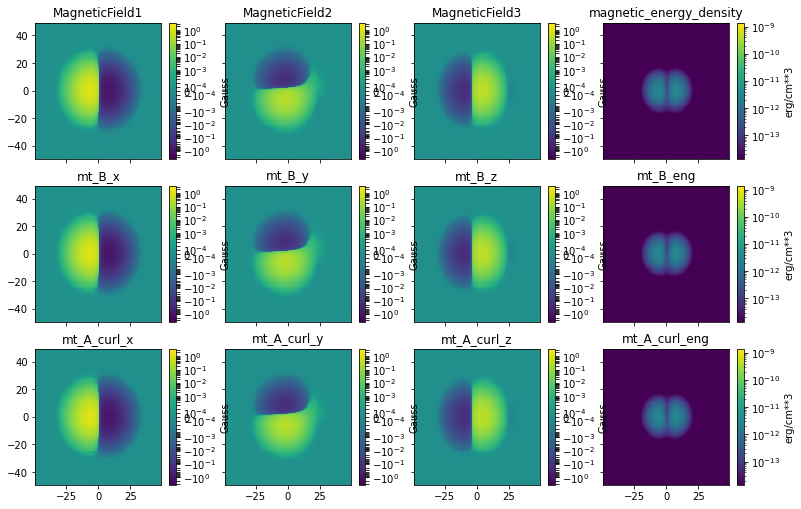

yt : [WARNING  ] 2021-08-19 08:32:21,670 Plotting ('gas', 'mt_A_curl_x'): Both positive and negative values. Min = -2.045776385049444 sqrt(code_mass)/(sqrt(code_length)*code_time), Max = 2.1026971347103114 sqrt(code_mass)/(sqrt(code_length)*code_time).
yt : [WARNING  ] 2021-08-19 08:32:21,671 Switching to symlog colorbar scaling.
yt : [WARNING  ] 2021-08-19 08:32:23,098 Plotting ('gas', 'mt_A_curl_z'): Both positive and negative values. Min = -0.3611085473032454 sqrt(code_mass)/(sqrt(code_length)*code_time), Max = 0.6780855669346143 sqrt(code_mass)/(sqrt(code_length)*code_time).
yt : [WARNING  ] 2021-08-19 08:32:23,099 Switching to symlog colorbar scaling.
yt : [WARNING  ] 2021-08-19 08:32:24,494 Plotting ('gas', 'mt_B_z'): Both positive and negative values. Min = -0.3622794427636276 sqrt(code_mass)/(sqrt(code_length)*code_time), Max = 0.6817817222666114 sqrt(code_mass)/(sqrt(code_length)*code_time).
yt : [WARNING  ] 2021-08-19 08:32:24,495 Switching to symlog colorbar scaling.
yt : [W

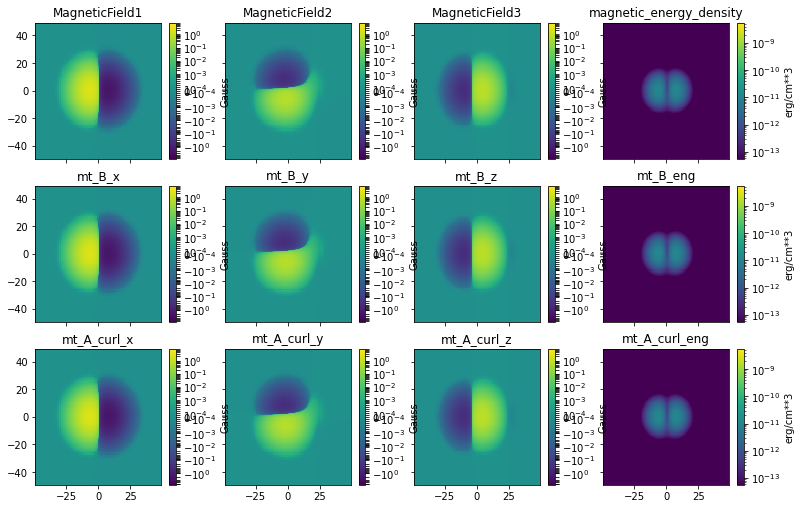

In [14]:
#Plot first dataset
for ds,mt_field in ((ds0,mt_field0),(ds1,mt_field1)):

    fields = ["MagneticField1","MagneticField2","MagneticField3","magnetic_energy_density",
              "mt_B_x","mt_B_y","mt_B_z","mt_B_eng",
              #err_mt_B_x","err_mt_B_y","err_mt_B_z","err_mt_B_eng",
              "mt_A_curl_x","mt_A_curl_y","mt_A_curl_z","mt_A_curl_eng",
              #err_mt_A_curl_x","err_mt_A_curl_y","err_mt_A_curl_z","err_mt_A_curl_eng",
              #"rel_err_mt_B_x","rel_err_mt_B_y","rel_err_mt_B_z","rel_err_mt_B_eng",
             ]
    field_units = {"MagneticField1":"Gauss","MagneticField2":"Gauss","MagneticField3":"Gauss","magnetic_energy_density":"erg/cm**3",
                   "mt_B_x":"Gauss","mt_B_y":"Gauss","mt_B_z":"Gauss","mt_B_eng":"erg/cm**3",
                   "mt_A_curl_x":"Gauss","mt_A_curl_y":"Gauss","mt_A_curl_z":"Gauss","mt_A_curl_eng":"erg/cm**3",
                   "err_mt_B_x":"Gauss","err_mt_B_y":"Gauss","err_mt_B_z":"Gauss","err_mt_B_eng":"erg/cm**3",
                   "rel_err_mt_B_x":"","rel_err_mt_B_y":"","rel_err_mt_B_z":"","rel_err_mt_B_eng":"",
                   "err_mt_A_curl_x":"Gauss","err_mt_A_curl_y":"Gauss","err_mt_A_curl_z":"Gauss","err_mt_A_curl_eng":"erg/cm**3",
                  }

    field_scale = 30*mt_field
    eng_scale = field_scale**2

    field_norms = {"MagneticField1":mpl.colors.SymLogNorm(vmin=-field_scale,vmax=field_scale,linthresh=1e-4*field_scale),
                   "MagneticField2":mpl.colors.SymLogNorm(vmin=-field_scale,vmax=field_scale,linthresh=1e-4*field_scale),
                   "MagneticField3":mpl.colors.SymLogNorm(vmin=-field_scale,vmax=field_scale,linthresh=1e-4*field_scale),
                   "magnetic_energy_density":mpl.colors.LogNorm(vmin=1e-15*eng_scale,vmax=1e-10*eng_scale),
                   "mt_B_x":mpl.colors.SymLogNorm(vmin=-field_scale,vmax=field_scale,linthresh=1e-4*field_scale),
                   "mt_B_y":mpl.colors.SymLogNorm(vmin=-field_scale,vmax=field_scale,linthresh=1e-4*field_scale),
                   "mt_B_z":mpl.colors.SymLogNorm(vmin=-field_scale,vmax=field_scale,linthresh=1e-4*field_scale),
                   "mt_B_eng":mpl.colors.LogNorm(vmin=1e-15*eng_scale,vmax=1e-10*eng_scale),
                   "mt_A_curl_x":mpl.colors.SymLogNorm(vmin=-field_scale,vmax=field_scale,linthresh=1e-4*field_scale),
                   "mt_A_curl_y":mpl.colors.SymLogNorm(vmin=-field_scale,vmax=field_scale,linthresh=1e-4*field_scale),
                   "mt_A_curl_z":mpl.colors.SymLogNorm(vmin=-field_scale,vmax=field_scale,linthresh=1e-4*field_scale),
                   "mt_A_curl_eng":mpl.colors.LogNorm(vmin=1e-15*eng_scale,vmax=1e-10*eng_scale),
                   "err_mt_B_x":mpl.colors.SymLogNorm(vmin=-field_scale,vmax=field_scale,linthresh=1e-4*field_scale),
                   "err_mt_B_y":mpl.colors.SymLogNorm(vmin=-field_scale,vmax=field_scale,linthresh=1e-4*field_scale),
                   "err_mt_B_z":mpl.colors.SymLogNorm(vmin=-field_scale,vmax=field_scale,linthresh=1e-4*field_scale),
                   "err_mt_B_eng":mpl.colors.SymLogNorm(vmin=-1e-10*eng_scale,vmax=1e-10*eng_scale,linthresh=1e-20*eng_scale),
                   "rel_err_mt_B_x":mpl.colors.LogNorm(vmin=1e-5,vmax=1),
                   "rel_err_mt_B_y":mpl.colors.LogNorm(vmin=1e-5,vmax=1),
                   "rel_err_mt_B_z":mpl.colors.LogNorm(vmin=1e-5,vmax=1),
                   "rel_err_mt_B_eng":mpl.colors.LogNorm(vmin=1e-3,vmax=1),
                   "err_mt_A_curl_x":mpl.colors.SymLogNorm(vmin=-field_scale,vmax=field_scale,linthresh=1e-4*field_scale),
                   "err_mt_A_curl_y":mpl.colors.SymLogNorm(vmin=-field_scale,vmax=field_scale,linthresh=1e-4*field_scale),
                   "err_mt_A_curl_z":mpl.colors.SymLogNorm(vmin=-field_scale,vmax=field_scale,linthresh=1e-4*field_scale),
                   "err_mt_A_curl_eng":mpl.colors.SymLogNorm(vmin=-1e-10*eng_scale,vmax=1e-10*eng_scale,linthresh=1e-20*eng_scale),        
                  }


    slc = yt.SlicePlot(ds,"x",fields,center=(0,0,0))

    for field,unit in field_units.items():
        slc.set_unit(field,unit)

    slc_frb = slc.data_source.to_frb((100,"kpc"), 512)

    nrows = int(len(fields)/4)
    fig,axes = plt.subplots(nrows=nrows,ncols=4,squeeze=False,figsize=(13,nrows*2.5+1),sharex="all",sharey="all")
    pcms = []
    for field,ax in zip(fields,axes.flatten()):
        frb = np.array(slc_frb[field])
        Y = np.array(slc_frb["y"].in_units("kpc"))
        Z = np.array(slc_frb["z"].in_units("kpc"))
        pcm = ax.pcolormesh(Y,Z,frb,norm=field_norms[field])

        fig.colorbar(pcm, ax=ax,label=field_units[field])
        pcms.append(pcms)
        ax.set_title(field)

    plt.show()

In [24]:
yt.SlicePlot(ds0,"x","vorticity_magnitude",center=(0,0,0),width=(0.05,"code_length"))

RuntimeError: yt attempted to read outside the boundaries of a non-periodic domain along dimension 1.
Region left edge = -0.10625000000000001 code_length, Region right edge = -0.06875 code_length
Dataset left edge = -0.1 code_length, Dataset right edge = 0.1 code_length

This commonly happens when trying to compute ghost cells up to the domain boundary. Two possible solutions are to select a smaller region that does not border domain edge (see https://yt-project.org/docs/analyzing/objects.html?highlight=region)
or override the periodicity with
ds.force_periodicity()

In [25]:
ds.smoothed_covering_grid(
    2, [0.0, 0.0, 0.0], ds.domain_dimensions * 2 ** 2
)

In [32]:
ds0.smoothed_covering_grid?

In [33]:
ds0.domain_left_edge